In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/dataset/brain-tumor-class.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/brain-tumor-class','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/brain-tumor-class','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 144.60it/s]


In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [10]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [11]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [12]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [13]:
history = model.fit(X_train,y_train,validation_split=0.2, epochs=25, verbose=1, batch_size=16,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/25
147/147 [==============================] - ETA: 0s - loss: 0.5064 - accuracy: 0.8084
Epoch 00001: val_accuracy improved from -inf to 0.88435, saving model to effnet.h5
147/147 [==============================] - 43s 206ms/step - loss: 0.5064 - accuracy: 0.8084 - val_loss: 0.4808 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 2/25
147/147 [==============================] - ETA: 0s - loss: 0.2523 - accuracy: 0.9153
Epoch 00002: val_accuracy improved from 0.88435 to 0.88605, saving model to effnet.h5
147/147 [==============================] - 27s 187ms/step - loss: 0.2523 - accuracy: 0.9153 - val_loss: 0.3892 - val_accuracy: 0.8861 - lr: 0.0010
Epoch 3/25
147/147 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9400
Epoch 00003: val_accuracy did not improve from 0.88605
147/147 [==============================] - 25s 173ms/step - loss: 0.1731 - accuracy: 0.9400 - val_loss: 0.4802 - val_accuracy: 0.8605 - lr: 0.0010
Epoch 4/25
147/147 [===========================

<Figure size 432x288 with 0 Axes>

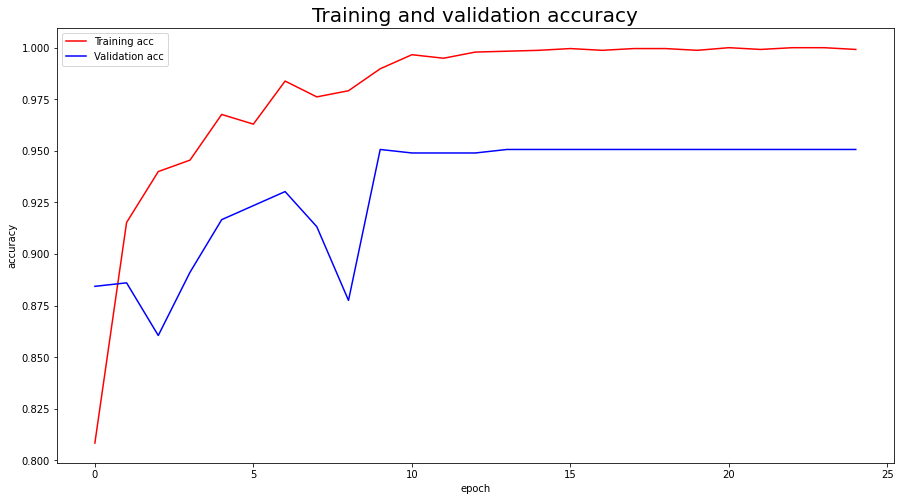

<Figure size 432x288 with 0 Axes>

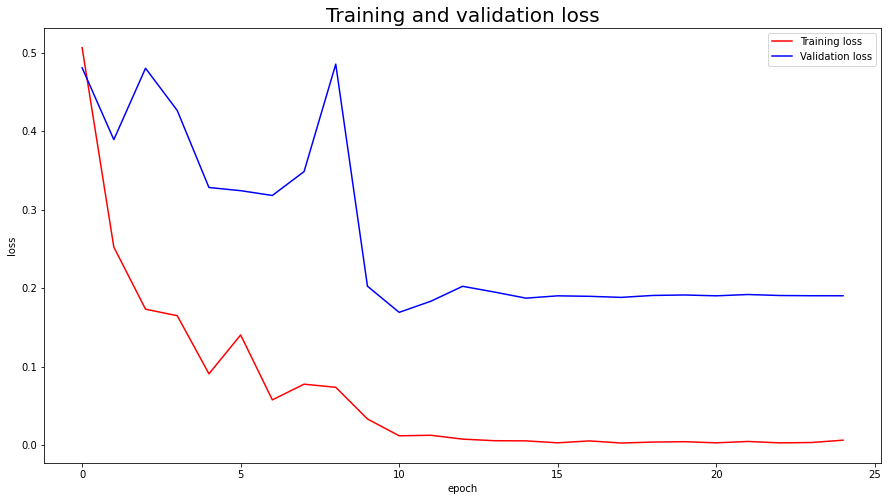

<Figure size 432x288 with 0 Axes>

In [14]:
#Graphing our training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', fontsize=20)
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()


plt.figure(figsize=(15, 8))

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=20)
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.figure()

In [15]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [16]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        93
           1       0.93      1.00      0.96        51
           2       0.96      0.97      0.96        96
           3       0.98      1.00      0.99        87

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



<Figure size 432x288 with 0 Axes>

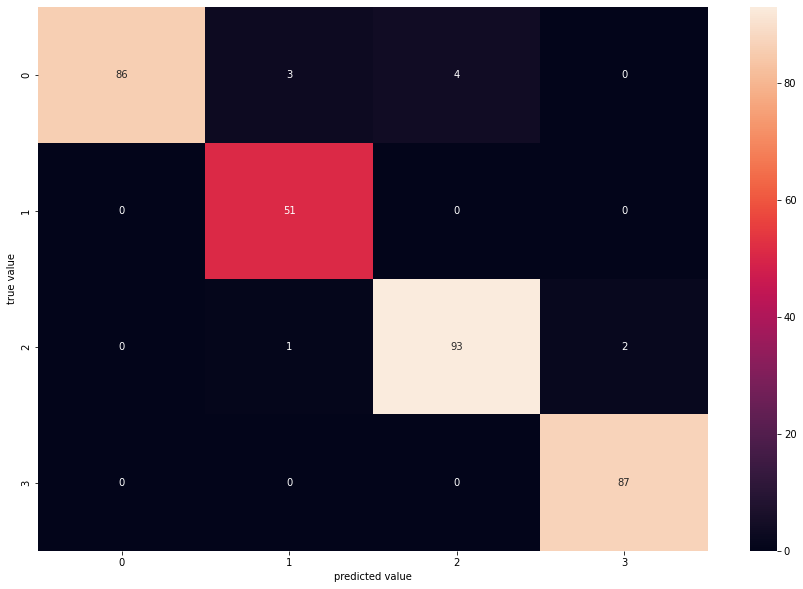

<Figure size 432x288 with 0 Axes>

In [17]:
#Prediction of test set
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

conf_matrix = confusion_matrix(y_test_new,pred)
sns.heatmap(conf_matrix,annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

plt.figure()

In [18]:
# Training Accuracy
train_pred = model.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
y_train_new = np.argmax(y_train, axis=1)

count_train = 0
for i in range(0, len(train_pred)):
  if train_pred[i] == y_train_new[i]:
    count_train += 1

x1 = count_train/len(train_pred)

# Validation Accuracy
test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)

count_test = 0
for i in range(0, len(test_pred)):
  if test_pred[i] == y_test_new[i]:
    count_test += 1

x2 = count_test/len(test_pred)

print('Training Accuracy  : %1.2f%%'%(x1*100))
print('Validation Accuracy: %1.2f%%'%(x2*100))

Training Accuracy  : 98.98%
Validation Accuracy: 96.94%
